In [1]:
from numba import cuda

# clear GPU cache
cuda.select_device(0)
cuda.close()

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


# get data from Collector/frames/*.jpg

frames = []
frameNumber = 0
while True:
    try:
        # look for the next frame in the frames folder stored as jpg
        image = Image.open('../Collector/frames/' + str(frameNumber) + '.jpg')
        frameNumber += 1
        # convert to numpy array
        image = np.array(image)
        # add the image to the end of the frames array
        frames = frames + [image]

    except Exception as e:
        break

In [2]:
# load in the steering data from the csv file
steering = []
with open('../Collector/frames/data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        steering = steering + [float(row[0])]

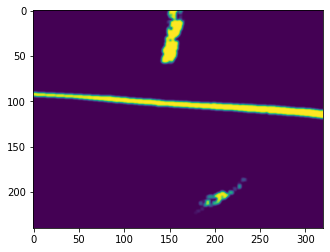

In [46]:
# preprocess the data to be used in the neural network
import cv2 as cv
import PIL
import imutils
from keras.preprocessing.image import img_to_array

processedFrames = []

#loop through the images and filter green pixels
for i in range(len(frames)):

    blur = cv.GaussianBlur(frames[i], (5, 5), 0)
    hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    # isolate green channel
    mask = cv.inRange(hsv, (30, 40, 100), (150, 255, 254))
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    mask = cv.GaussianBlur(mask, (5, 5), 0)

    # find contours
    contors = cv.findContours(mask, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
    contors = imutils.grab_contours(contors)
    contmask = np.zeros(mask.shape, dtype="uint8") * 255

    for c in contors:
        if cv.contourArea(c) > 715:
            cv.drawContours(contmask, [c], -1, (255, 255, 255), -1)

    # mix the contour mask with the mask 50%
    mask = cv.bitwise_and(mask, contmask)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    # resize by half
    mask = cv.resize(mask, (0, 0), fx=0.5, fy=0.5)

    processedFrames.append(mask)
    
    

# show a random image from the processed frames
plt.imshow(processedFrames[np.random.randint(0, len(processedFrames))])

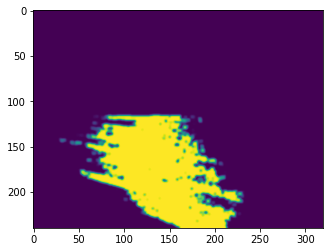

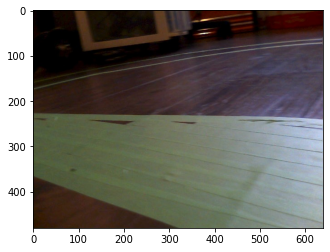

In [59]:
randomFrameNumber = np.random.randint(0, len(processedFrames))
plt.imshow(processedFrames[randomFrameNumber])
plt.show()
plt.imshow(frames[randomFrameNumber])

In [86]:
processedFrames = np.array(processedFrames)
print(len(processedFrames))

# shuffle the data the same 
from sklearn.utils import shuffle
processedFrames, steering = shuffle(processedFrames, steering, random_state=0)

# remove 50% of the data
processedFrames_minimized = processedFrames[:int(len(processedFrames) * 1)]
steering_minimized = steering[:int(len(steering) * 1)] 

print(len(processedFrames_minimized))

12284
12284


In [87]:
# split the data into training and validation sets 
from sklearn.model_selection import train_test_split

traning_data, validation_data, traning_steering, validation_steering = train_test_split(processedFrames_minimized, steering_minimized, test_size=0.2, random_state=0)

In [61]:
# create a model with 3 convolutional layers and 1 fully connected layer
# that outputs a steering angle when given an image and steering data as input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import time

K.clear_session()

# use cpu instead of gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print("Creating model")
model = Sequential()
model.add(Conv2D(8, (5, 5),padding="same", strides=(2, 2), input_shape=(320, 240, 1), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(12, (5, 5), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())



model.add(Dense(1000))
model.add(Activation('sigmoid'))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))


print('compiling model...')
# compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

print('fitting model...')
# train the model
model.fit(traning_data, np.array(traning_steering) , epochs=100, verbose=1, validation_data=(validation_data, np.array(validation_steering)), shuffle=True, batch_size=256)
# graph the loss and accuracy
plt.plot(model.history.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

# print difference between the start and end loss
print(model.history.history['loss'][-1] - model.history.history['loss'][0])

#show what each layer looks like
model.summary()

#clear session
print('clearing session')
K.clear_session()



Creating model
compiling model...
fitting model...


NameError: name 'traning_data' is not defined

In [8]:
model = ks.models.load_model('atlas4.h5')

In [17]:
# print rsquared and mean squared error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('r squared: ' + str(r2_score(steering, model.predict(processedFrames))))
print('mean squared error: ' + str(mean_squared_error(steering, model.predict(processedFrames))))

r squared: -1.1323250206021753
mean squared error: 883.9938469588758


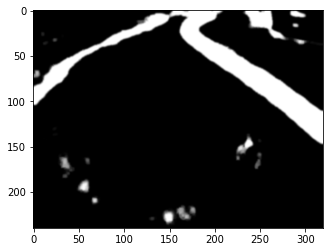

[[56.41972]]


In [16]:
frameNumber = 9
# grab the first image from the frames array
image = processedFrames[frameNumber]




# show the image and steering data
plt.imshow(image, cmap='gray')
plt.show()

# predict the steering angle for the first image
prediction = model.predict(image.reshape(1, 240, 320, 1))
print(prediction)

In [17]:
#save the model
model.save('atlas3.h5')

In [136]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [7]:
from numba import cuda
# clear session
print('clearing session')
cuda.select_device(0)
cuda.close()


clearing session
